### #4. Dual Layer Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**1) 데이터 불러오기**

In [4]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

**2) 모델 클래스 생성**

In [10]:
class DualLayer:
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def init_weight(self, n_features):
        self.w1 = np.ones((n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.ones((self.units, 1))
        self.b2 = 0
        
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
        
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2
    
    def backprop(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def reg_loss(self):
        reg_1 = self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2)))
        reg_2 = self.l2 / 2 * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2))
        return reg_1, reg_2
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1 - 1e-10)
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
        
    def predict(self, x):
        z = self.forpass(x)
        return z > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def fit(self, x, y, x_val=None, y_val=None, epochs=100):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.init_weight(x.shape[1])
        
        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1 - 1e-10)
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(x_val, y_val)

**3) 훈련 데이터 & 검증 데이터 분할**

In [5]:
from sklearn.model_selection import train_test_split

X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, stratify=y_train_all, random_state=42
)

**4) 데이터 전처리**

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

**5) 모델 훈련**

In [11]:
dual_layer = DualLayer()
dual_layer.fit(X_train_scaled, y_train, X_val_scaled, y_val)

In [12]:
print('검증 데이터 성능 정확도: {:.2f}'.format(dual_layer.score(X_val_scaled, y_val)))

검증 데이터 성능 정확도: 0.83


**6) 가중치 초기화 개선 - 랜덤 숫자로 초기화**

In [13]:
class RandomInitNetwork(DualLayer):
    def init_weight(self, n_features):
        self.w1 = np.random.normal(0, 1, (n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, 1))
        self.b2 = 0

In [14]:
random_init = RandomInitNetwork()
random_init.fit(X_train_scaled, y_train, X_val_scaled, y_val)

In [15]:
print('검증 데이터 성능 정확도: {:.2f}'.format(random_init.score(X_val_scaled, y_val)))

검증 데이터 성능 정확도: 0.97


**7) 손실 그래프**

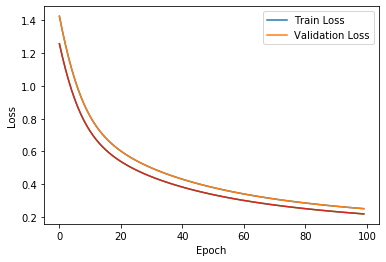

In [16]:
plt.plot(random_init.losses)
plt.plot(random_init.val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()